# BERT Base 
Uncased Embeddings

Using bert uncased embeddings to find a representative word embedding of trivial and non-trivial messages (from the training sentences). Classify each new sentence based on the Euclidean distance from the representative embeddings.

In [93]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf

from scipy.spatial.distance import cosine

In [94]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [95]:
spam_df = pd.read_excel('../../src/data/spam.xlsx')
checkmate_df = pd.read_csv('../../src/data/CheckMate_Messages_Table.csv')

In [96]:
checkmate_df['is_trivial'] = (checkmate_df['taggedCategory']=='Trivial')
# Not all sentences are imported as strings
checkmate_df['text'] = checkmate_df['text'].astype('str')

# Remove empty rows
spam_df = spam_df.iloc[:, 1:3]
# Rename columns
spam_df.columns = ['text', 'is_trivial']
# Not all sentences are imported as strings
spam_df['text'] = spam_df['text'].astype('str')

In [97]:
spam_df['text'] = (spam_df['text'].apply(lambda x: "[CLS] " + x + " [SEP]"))
# print(spam_df)
spam_df['token_ids'] = spam_df['text'].apply(lambda x: tokenizer.encode(x, truncation=True))
# print(spam_df)

checkmate_df['text'] = (checkmate_df['text'].apply(lambda x: "[CLS] " + x + " [SEP]"))
# print(checkmate_df)
checkmate_df['token_ids'] = checkmate_df['text'].apply(lambda x: tokenizer.encode(x, truncation=True))
# print(checkmate_df)

In [100]:
for i in spam_df['token_ids']:
    if len(i) > 512:
        print('gth longer than 512')
for i in checkmate_df['token_ids']:
    if len(i) > 512:
        print('Length longer than 512')

In [101]:
# Creating segment ids for the sentence - since all belong to the same sentence it is all 1
checkmate_df['segment_ids'] = (checkmate_df['token_ids'].apply(lambda x: [1] * len(x)))
spam_df['segment_ids'] = (spam_df['token_ids'].apply(lambda x: [1] * len(x)))

In [102]:
temp = checkmate_df['segment_ids']
print(type(temp[0]))
print(temp[0])

<class 'list'>
[1, 1, 1, 1, 1]


In [103]:
# Turn all the list of token ids/segment ids into tensors
spam_df['tensor_token'] = spam_df.apply(lambda x: torch.tensor([x['token_ids']]), axis=1)
spam_df['tensor_segment'] = spam_df.apply(lambda x: torch.tensor([x['segment_ids']]), axis=1)

checkmate_df['tensor_token'] = checkmate_df.apply(lambda x: torch.tensor([x['token_ids']]), axis=1)
checkmate_df['tensor_segment'] = checkmate_df.apply(lambda x: torch.tensor([x['segment_ids']]), axis=1)

In [104]:
spam_df_train, spam_df_test = train_test_split(spam_df, test_size=0.8, stratify=spam_df['is_trivial'])
print(len(spam_df_train))
print(len(spam_df_test))

1114
4457


In [105]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    spam_df_train['hidden_states'] = spam_df_train.apply(lambda x: model(x['tensor_token'],x['tensor_segment'])[2], axis=1)

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    spam_df_test['hidden_states'] = spam_df_test.apply(lambda x: model(x['tensor_token'],x['tensor_segment'])[2], axis=1)

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    checkmate_df['hidden_states'] = checkmate_df.apply(lambda x: model(x['tensor_token'],x['tensor_segment'])[2], axis=1)

In [122]:
# Printing to visualise values
# `hidden_states` has shape [13 x 1 x number of tokens x 768]
# `token_vecs` is a tensor with shape [number of tokens x 768]
# [# layers, # batches, # tokens, # features]
spam_df_train['hidden_states'].head(10).apply(lambda x: print(x[-2][0].shape))

torch.Size([41, 768])
torch.Size([43, 768])
torch.Size([10, 768])
torch.Size([19, 768])
torch.Size([22, 768])
torch.Size([10, 768])
torch.Size([21, 768])
torch.Size([8, 768])
torch.Size([17, 768])
torch.Size([27, 768])


4391    None
3506    None
4506    None
4711    None
4302    None
558     None
1935    None
3375    None
4661    None
1926    None
Name: hidden_states, dtype: object

In [123]:
# Get sentence embedding by taking the mean of feature tensor of all the tokens in the second last layer
# x is the indexing the -2 layer (second last) and then [0] is for batch 0, left with tokens and feature vectors
spam_df_train['sentence_embedding'] = spam_df_train['hidden_states'].apply(lambda x: torch.mean(x[-2][0], dim=0))
spam_df_test['sentence_embedding'] = spam_df_test['hidden_states'].apply(lambda x: torch.mean(x[-2][0], dim=0))
checkmate_df['sentence_embedding'] = checkmate_df['hidden_states'].apply(lambda x: torch.mean(x[-2][0], dim=0))

In [124]:
# separate the sentence embeddings of non trivial and trivial messages
spam_df_train_not_trivial = spam_df_train[spam_df_train['is_trivial'] == False]
spam_df_train_trivial = spam_df_train[spam_df_train['is_trivial'] == True]

In [125]:
# create tensors from the series spam_df_train['sentence_embedding]
tensor_train_not_trivial = torch.stack([t for t in spam_df_train_not_trivial['sentence_embedding']])
tensor_train_trivial = torch.stack([t for t in spam_df_train_trivial['sentence_embedding']])

In [126]:
# create a representative tensor of size [1,768] for non-trivial and trivial
rep_not_trivial = torch.mean(tensor_train_not_trivial, dim=0)
rep_trivial = torch.mean(tensor_train_trivial, dim=0)

In [127]:
def classify_trivial(v):
    distance_from_not_trivial = cosine(rep_not_trivial, v)
    distance_from_trivial = cosine(rep_trivial, v)
    if distance_from_trivial > distance_from_not_trivial:
        return False
    else: 
        return True

### Evaluate
Get results of using the cosine similarity method on both spam_df_test and checkmate_df

In [128]:
spam_df_test['prediction'] = spam_df_test['sentence_embedding'].apply(lambda x: classify_trivial(x))
checkmate_df['prediction'] = checkmate_df['sentence_embedding'].apply(lambda x: classify_trivial(x))

#### Results for spam_df_test

In [129]:
spam_predicted_vs_output = pd.concat([spam_df_test['text'], spam_df_test['is_trivial'], spam_df_test['prediction']], axis=1)
# predicted_vs_output = predicted_vs_output.rename(columns={'is_trivial':'target', 'text':'prediction'})
spam_predicted_vs_output.columns = ['text', 'target','prediction']

print(spam_predicted_vs_output)

                                                   text  target  prediction
5351  [CLS] Free video camera phones with Half Price...       0       False
3766  [CLS] Night sweet, sleep well! I've just been ...       1        True
326   [CLS] Hey i will be late ah... Meet you at 945...       1        True
3111  [CLS] Good morning princess! Happy New Year! [...       1        True
1780   [CLS] Who's there say hi to our drugdealer [SEP]       1        True
...                                                 ...     ...         ...
2787      [CLS] Well that must be a pain to catch [SEP]       1        True
3579  [CLS] Ever green quote ever told by Jerry in c...       1        True
4605             [CLS] Aah bless! How's your arm? [SEP]       1        True
2205        [CLS] I'll reach in ard 20 mins ok... [SEP]       1        True
702                  [CLS] Hey. You got any mail? [SEP]       1        True

[4457 rows x 3 columns]


In [130]:
# Calculate the recall of this methodology
true_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==True)])
true_non_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==False)])

false_non_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==False)])
false_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==True)])

recall = true_non_trivial/(true_non_trivial+false_trivial)
accuracy = (true_trivial+true_non_trivial)/(true_trivial+true_non_trivial+false_trivial+false_non_trivial)

In [131]:
print(f'Recall is: {recall*100}%')
print(f'Accuracy is: {accuracy*100}%')

print(f'true_trivial is: {true_trivial}')
print(f'true_non_trivial is: {true_non_trivial}')
print(f'false_non_trivial is: {false_non_trivial}')
print(f'false_trivial is: {false_trivial}')

Recall is: 95.87458745874588%
Accuracy is: 97.41978909580436%
true_trivial is: 3761
true_non_trivial is: 581
false_non_trivial is: 90
false_trivial is: 25


#### Results for checkmate_df

In [132]:
checkmate_predicted_vs_output = pd.concat([checkmate_df['text'], checkmate_df['is_trivial'], checkmate_df['prediction'], checkmate_df['taggedCategory']], axis=1)
# predicted_vs_output = predicted_vs_output.rename(columns={'is_trivial':'target', 'text':'prediction'})
checkmate_predicted_vs_output.columns = ['text', 'target','prediction','category']

print(checkmate_predicted_vs_output)

                                                 text  target  prediction  \
0                                     [CLS] nan [SEP]   False        True   
1   [CLS] https://www.mas.gov.sg/news/media-releas...   False       False   
2   [CLS] TN 95546718362782 is out for del. Allow ...   False       False   
3   [CLS] 🚩🚩🚩 *"You flag, we check"* 🔍🔍🔍\n\nNot su...   False       False   
4   [CLS] https://form.gov.sg/63f594b42413ea001183...   False       False   
..                                                ...     ...         ...   
81  [CLS] [SHIN MIN CONTEST] Happycall Jumbo 双面锅等你...   False       False   
82  [CLS] Hello, sorry to bother you, I'm Nico fro...   False       False   
83  [CLS] Hello, my name is Sarah, from CME Group....   False       False   
84  [CLS] LTA: Notice As no valid E-tag detected i...   False       False   
85  [CLS] Excuse me, this is Stella, have you arra...   False        True   

             category  
0   Info/News/Opinion  
1   Info/News/Opinion  
2  

In [133]:
# Calculate the recall of this methodology
true_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==True)])
true_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==False)])

false_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==False)])
false_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==True)])

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

In [134]:
print(f'Recall is: {recall*100}%')
print(f'Accuracy is: {accuracy*100}%')

print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

Recall is: 80.95238095238095%
Accuracy is: 84.88372093023256%
true_trivial is: 22
true_non_trivial is: 51
false_non_trivial is: 1
false_trivial is: 12


In [135]:
print(false_non_trivial)

                                                 text  target  prediction  \
72  [CLS] If you receive a scam message like this ...    True       False   

   category  
72  Trivial  


In [136]:
print(false_trivial)

                                                 text  target  prediction  \
0                                     [CLS] nan [SEP]   False        True   
8                                     [CLS] nan [SEP]   False        True   
12  [CLS] Hey Jolyn! We haven't seen you in the st...   False        True   
19  [CLS] Hi, last year one of my colleague met yo...   False        True   
22  [CLS] Hi! I pray this msg find you in good hea...   False        True   
33  [CLS] Ionizing radiation can affect the atoms ...   False        True   
37   [CLS] I can withdraw my CPF only at age 65 [SEP]   False        True   
38                 [CLS] 9/11 attack was a scam [SEP]   False        True   
41  [CLS] Hello \nsorry to bother you, is this Kev...   False        True   
48                                    [CLS] nan [SEP]   False        True   
51  [CLS] Hi, I'm. Felicia.  from *SG, Employment ...   False        True   
85  [CLS] Excuse me, this is Stella, have you arra...   False        True   

### Learnings/Room for improvement

Out of the 15 wrongly classified messages:
2 - nan values
    - One is an image
    - One is an empty nan messsage

Solution: Automatically classify nan of images as non-trivial


Types of these messages
6 - unsure values
4 - scam
4 - info 
1 - legitimate

Too strict criteria of deciding non-trivial - most of the non-trivial predicitions are correct. Need to be more likely to predict messages as non-trivial instead
However, a higher percentage of the trivial predicitions were wrong.
Based on the requirements of the model, it is better to be strict on deciding criteria on whether something is deemed trivial

Next steps:

- Incorporate the checkmate data into the training dataset and see if it shifts the representative vector significantly
- Test different methods of determining sentence embedding
- Classificiation model layer on top of the sentence embedding


## Representative vector using checkmate data

In [137]:
# Use both spam and checkmate data to create representative embedding
rep_df = pd.concat([spam_df_train, checkmate_df], axis = 0)

In [138]:
print(f'Ratio of spam_df_train to checkmate_df: {len(checkmate_df)/len(spam_df_train)*100}%')

Ratio of spam_df_train to checkmate_df: 7.719928186714542%


In [199]:
# separate the sentence embeddings of non trivial and trivial messages
rep_df_train_not_trivial = rep_df[rep_df['is_trivial'] == False]
rep_df_train_trivial = rep_df[rep_df['is_trivial'] == True]

In [140]:
# create tensors from the series spam_df_train['sentence_embedding]
tensor_train_not_trivial_2 = torch.stack([t for t in rep_df_train_not_trivial['sentence_embedding']])
tensor_train_trivial_2 = torch.stack([t for t in rep_df_train_trivial['sentence_embedding']])

In [141]:
# create a representative tensor of size [1,768] for non-trivial and trivial
rep_not_trivial_2 = torch.mean(tensor_train_not_trivial_2, dim=0)
rep_trivial_2 = torch.mean(tensor_train_trivial_2, dim=0)

In [142]:
# Update classify trivial function using new representative embeddings
def classify_trivial(v):
    distance_from_not_trivial = cosine(rep_not_trivial_2, v)
    distance_from_trivial = cosine(rep_trivial_2, v)
    if distance_from_trivial > distance_from_not_trivial:
        return False
    else: 
        return True

### Evaluate
Get results of using the cosine similarity method on both spam_df_test and checkmate_df

In [143]:
spam_df_test['prediction'] = spam_df_test['sentence_embedding'].apply(lambda x: classify_trivial(x))
checkmate_df['prediction'] = checkmate_df['sentence_embedding'].apply(lambda x: classify_trivial(x))

#### Results for spam_df_test

In [144]:
spam_predicted_vs_output = pd.concat([spam_df_test['text'], spam_df_test['is_trivial'], spam_df_test['prediction']], axis=1)
# predicted_vs_output = predicted_vs_output.rename(columns={'is_trivial':'target', 'text':'prediction'})
spam_predicted_vs_output.columns = ['text', 'target','prediction']

print(spam_predicted_vs_output)

                                                   text  target  prediction
5351  [CLS] Free video camera phones with Half Price...       0       False
3766  [CLS] Night sweet, sleep well! I've just been ...       1        True
326   [CLS] Hey i will be late ah... Meet you at 945...       1        True
3111  [CLS] Good morning princess! Happy New Year! [...       1        True
1780   [CLS] Who's there say hi to our drugdealer [SEP]       1        True
...                                                 ...     ...         ...
2787      [CLS] Well that must be a pain to catch [SEP]       1        True
3579  [CLS] Ever green quote ever told by Jerry in c...       1        True
4605             [CLS] Aah bless! How's your arm? [SEP]       1        True
2205        [CLS] I'll reach in ard 20 mins ok... [SEP]       1        True
702                  [CLS] Hey. You got any mail? [SEP]       1        True

[4457 rows x 3 columns]


In [145]:
# Calculate the recall of this methodology
true_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==True)])
true_non_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==False)])

false_non_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==False)])
false_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==True)])

recall = true_non_trivial/(true_non_trivial+false_trivial)
accuracy = (true_trivial+true_non_trivial)/(true_trivial+true_non_trivial+false_trivial+false_non_trivial)

In [146]:
print(f'Recall is: {recall*100}%')
print(f'Accuracy is: {accuracy*100}%')

print(f'true_trivial is: {true_trivial}')
print(f'true_non_trivial is: {true_non_trivial}')
print(f'false_non_trivial is: {false_non_trivial}')
print(f'false_trivial is: {false_trivial}')

Recall is: 96.20462046204621%
Accuracy is: 96.90374691496523%
true_trivial is: 3736
true_non_trivial is: 583
false_non_trivial is: 115
false_trivial is: 23


#### Results for checkmate_df

In [147]:
checkmate_predicted_vs_output = pd.concat([checkmate_df['text'], checkmate_df['is_trivial'], checkmate_df['prediction'], checkmate_df['taggedCategory']], axis=1)
# predicted_vs_output = predicted_vs_output.rename(columns={'is_trivial':'target', 'text':'prediction'})
checkmate_predicted_vs_output.columns = ['text', 'target','prediction','category']

print(checkmate_predicted_vs_output)

                                                 text  target  prediction  \
0                                     [CLS] nan [SEP]   False        True   
1   [CLS] https://www.mas.gov.sg/news/media-releas...   False       False   
2   [CLS] TN 95546718362782 is out for del. Allow ...   False       False   
3   [CLS] 🚩🚩🚩 *"You flag, we check"* 🔍🔍🔍\n\nNot su...   False       False   
4   [CLS] https://form.gov.sg/63f594b42413ea001183...   False       False   
..                                                ...     ...         ...   
81  [CLS] [SHIN MIN CONTEST] Happycall Jumbo 双面锅等你...   False       False   
82  [CLS] Hello, sorry to bother you, I'm Nico fro...   False       False   
83  [CLS] Hello, my name is Sarah, from CME Group....   False       False   
84  [CLS] LTA: Notice As no valid E-tag detected i...   False       False   
85  [CLS] Excuse me, this is Stella, have you arra...   False        True   

             category  
0   Info/News/Opinion  
1   Info/News/Opinion  
2  

In [148]:
# Calculate the recall of this methodology
true_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==True)])
true_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==False)])

false_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==False)])
false_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==True)])

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

In [149]:
print(f'Recall is: {recall*100}%')
print(f'Accuracy is: {accuracy*100}%')

print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

Recall is: 87.3015873015873%
Accuracy is: 87.20930232558139%
true_trivial is: 20
true_non_trivial is: 55
false_non_trivial is: 3
false_trivial is: 8


In [150]:
print(false_non_trivial)

                                                 text  target  prediction  \
64  [CLS] Noted. Sorry about this. I misread your ...    True       False   
72  [CLS] If you receive a scam message like this ...    True       False   
76  [CLS] FYI, please. Please kindly adhere to the...    True       False   

   category  
64  Trivial  
72  Trivial  
76  Trivial  


In [151]:
print(false_trivial)

                                                 text  target  prediction  \
0                                     [CLS] nan [SEP]   False        True   
8                                     [CLS] nan [SEP]   False        True   
12  [CLS] Hey Jolyn! We haven't seen you in the st...   False        True   
37   [CLS] I can withdraw my CPF only at age 65 [SEP]   False        True   
38                 [CLS] 9/11 attack was a scam [SEP]   False        True   
41  [CLS] Hello \nsorry to bother you, is this Kev...   False        True   
48                                    [CLS] nan [SEP]   False        True   
85  [CLS] Excuse me, this is Stella, have you arra...   False        True   

             category  
0   Info/News/Opinion  
8          Legitimate  
12             Unsure  
37  Info/News/Opinion  
38  Info/News/Opinion  
41             Unsure  
48               Scam  
85             Unsure  


By incorporating checkmate data in to the representative data, the incorrectly classified data for non trivial was reduced from 15 to 8.
Most of the improvements were in the area of scam (4->1) and unsure (6->2).ll and accuracy of the spam dataset did not reduce significantly.

## Alternative sentence embedding

In [162]:
# Output of the model is a modeloutput object
# sample_test_1.hidden_states == same as sample_test_1[2] which is currently stored in the hidden_states column
# other index of the output object is not particularly useful in this calculation
with torch.no_grad():

    checkmate_df['output'] = checkmate_df.apply(lambda x: model(x['tensor_token'],x['tensor_segment']), axis=1)

In [195]:
# print(checkmate_df['output'])
test = checkmate_df['output']
print(type(test[0]))
sample_test_1 = test[0]

print(type(sample_test_1[0]))
print(type(sample_test_1[1]))
print(type(sample_test_1[2]))

hidden_state_of_1 = sample_test_1[2]
print(type(hidden_state))
print(len(hidden_state)) # 13 layers
print(len(hidden_state[0])) # 1 batch
print(len(hidden_state[0][0])) # Number of tokens in sentence
print(len(hidden_state[0][0][0])) # 768 features

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tuple'>
<class 'tuple'>
13
1
42
768


(tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.2239, -0.1747, -0.4094,  ...,  0.2746,  0.3853,  0.0379],
         [-0.8983, -0.8071, -0.7236,  ...,  1.0387,  0.0843, -0.2246],
         [-0.3461, -0.1936, -0.1552,  ..., -0.1593,  0.1526, -0.1786],
         [-0.3643, -0.1617,  0.0902,  ..., -0.1785,  0.1282, -0.0451]]]), tensor([[[ 2.3898e-01, -1.2608e-05, -1.1209e-01,  ..., -1.2450e-01,
           1.6080e-02, -2.6449e-03],
         [ 1.9596e-01, -2.5544e-02, -8.5134e-02,  ..., -1.3548e-02,
           1.8778e-01, -4.9398e-02],
         [-3.8239e-01, -7.4365e-01, -7.3680e-01,  ...,  4.6889e-01,
          -1.6182e-01, -3.4292e-01],
         [-2.4948e-01,  8.7029e-02, -1.4371e-01,  ..., -1.9690e-01,
           4.5584e-01, -3.0626e-02],
         [-2.5638e-01,  1.1280e-01, -3.8011e-02,  ..., -2.3235e-01,
           4.1467e-01,  1.4784e-01]]]), tensor([[[ 0.0810, -0.1788, -0.1567,  ...,  0.0202,  0.0255,  0.0910],
         [ 0.0500, -0.1459, -0.1104,  ...,

### Sentence Embedding = Sum of Last 4 Layers 

In [196]:
print(type(hidden_state_of_1[-4:]))
print(len(hidden_state_of_1[-4:]))

# Stack the tuple of tensors for the last 4 layers into one tensor
# Find the sum of all the tensors
tensor_l4l = torch.stack(hidden_state_of_1[-4:])
print(tensor_l4l.shape)
sum_l4l = torch.mean(tensor_l4l, dim=(0,1,2))
print(sum_l4l.shape)

<class 'tuple'>
4
torch.Size([4, 1, 5, 768])
torch.Size([768])


In [239]:
# Get sentence embedding by taking the mean of feature tensor of all the tokens in the second last layer
# x is the indexing the -2 layer (second last) and then [0] is for batch 0, left with tokens and feature vectors
spam_df_train['sentence_embedding2'] = spam_df_train['hidden_states'].apply(lambda x: torch.sum(x[-4:][0], dim=(0,1)))
spam_df_test['sentence_embedding2'] = spam_df_test['hidden_states'].apply(lambda x: torch.sum(x[-4:][0], dim=(0,1)))
checkmate_df['sentence_embedding2'] = checkmate_df['hidden_states'].apply(lambda x: torch.sum(x[-4:][0], dim=(0,1)))

In [240]:
# t = spam_df_train['sentence_embedding2']
# print(t)
# print(t[4391].shape)

In [241]:
# Use both spam and checkmate data to create representative embedding
rep_df = pd.concat([spam_df_train, checkmate_df], axis = 0)

In [242]:
# separate the sentence embeddings of non trivial and trivial messages
rep_df_train_not_trivial = rep_df[rep_df['is_trivial'] == False]
rep_df_train_trivial = rep_df[rep_df['is_trivial'] == True]

In [243]:
# create tensors from the series spam_df_train['sentence_embedding]
tensor_train_not_trivial_3 = torch.stack([t for t in rep_df_train_not_trivial['sentence_embedding2']])
tensor_train_trivial_3 = torch.stack([t for t in rep_df_train_trivial['sentence_embedding2']])

In [244]:
# create a representative tensor of size [1,768] for non-trivial and trivial
rep_not_trivial_3 = torch.mean(tensor_train_not_trivial_3, dim=0)
rep_trivial_3 = torch.mean(tensor_train_trivial_3, dim=0)

In [245]:
# Update classify trivial function using new representative embeddings
def classify_trivial(v):
    distance_from_not_trivial = cosine(rep_not_trivial_3, v)
    distance_from_trivial = cosine(rep_trivial_3, v)
    if distance_from_trivial > distance_from_not_trivial:
        return False
    else: 
        return True

### Evaluate
Get results of using the cosine similarity method on both spam_df_test and checkmate_df

In [246]:
spam_df_test['prediction'] = spam_df_test['sentence_embedding2'].apply(lambda x: classify_trivial(x))
checkmate_df['prediction'] = checkmate_df['sentence_embedding2'].apply(lambda x: classify_trivial(x))

#### Results for spam_df_test

In [247]:
spam_predicted_vs_output = pd.concat([spam_df_test['text'], spam_df_test['is_trivial'], spam_df_test['prediction']], axis=1)
# predicted_vs_output = predicted_vs_output.rename(columns={'is_trivial':'target', 'text':'prediction'})
spam_predicted_vs_output.columns = ['text', 'target','prediction']

print(spam_predicted_vs_output)

                                                   text  target  prediction
5351  [CLS] Free video camera phones with Half Price...       0       False
3766  [CLS] Night sweet, sleep well! I've just been ...       1        True
326   [CLS] Hey i will be late ah... Meet you at 945...       1        True
3111  [CLS] Good morning princess! Happy New Year! [...       1        True
1780   [CLS] Who's there say hi to our drugdealer [SEP]       1        True
...                                                 ...     ...         ...
2787      [CLS] Well that must be a pain to catch [SEP]       1        True
3579  [CLS] Ever green quote ever told by Jerry in c...       1        True
4605             [CLS] Aah bless! How's your arm? [SEP]       1        True
2205        [CLS] I'll reach in ard 20 mins ok... [SEP]       1        True
702                  [CLS] Hey. You got any mail? [SEP]       1        True

[4457 rows x 3 columns]


In [248]:
# Calculate the recall of this methodology
true_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==True)])
true_non_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==False)])

false_non_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==True) & (spam_predicted_vs_output['prediction']==False)])
false_trivial = len(spam_predicted_vs_output[(spam_predicted_vs_output['target']==False) & (spam_predicted_vs_output['prediction']==True)])

recall = true_non_trivial/(true_non_trivial+false_trivial)
accuracy = (true_trivial+true_non_trivial)/(true_trivial+true_non_trivial+false_trivial+false_non_trivial)

In [249]:
print(f'Recall is: {recall*100}%')
print(f'Accuracy is: {accuracy*100}%')

print(f'true_trivial is: {true_trivial}')
print(f'true_non_trivial is: {true_non_trivial}')
print(f'false_non_trivial is: {false_non_trivial}')
print(f'false_trivial is: {false_trivial}')

Recall is: 93.23432343234323%
Accuracy is: 97.98070450975993%
true_trivial is: 3802
true_non_trivial is: 565
false_non_trivial is: 49
false_trivial is: 41


#### Results for checkmate_df

In [250]:
checkmate_predicted_vs_output = pd.concat([checkmate_df['text'], checkmate_df['is_trivial'], checkmate_df['prediction'], checkmate_df['taggedCategory']], axis=1)
# predicted_vs_output = predicted_vs_output.rename(columns={'is_trivial':'target', 'text':'prediction'})
checkmate_predicted_vs_output.columns = ['text', 'target','prediction','category']

print(checkmate_predicted_vs_output)

                                                 text  target  prediction  \
0                                     [CLS] nan [SEP]   False        True   
1   [CLS] https://www.mas.gov.sg/news/media-releas...   False       False   
2   [CLS] TN 95546718362782 is out for del. Allow ...   False       False   
3   [CLS] 🚩🚩🚩 *"You flag, we check"* 🔍🔍🔍\n\nNot su...   False       False   
4   [CLS] https://form.gov.sg/63f594b42413ea001183...   False       False   
..                                                ...     ...         ...   
81  [CLS] [SHIN MIN CONTEST] Happycall Jumbo 双面锅等你...   False       False   
82  [CLS] Hello, sorry to bother you, I'm Nico fro...   False       False   
83  [CLS] Hello, my name is Sarah, from CME Group....   False        True   
84  [CLS] LTA: Notice As no valid E-tag detected i...   False       False   
85  [CLS] Excuse me, this is Stella, have you arra...   False        True   

             category  
0   Info/News/Opinion  
1   Info/News/Opinion  
2  

In [251]:
# Calculate the recall of this methodology
true_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==True)])
true_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==False)])

false_non_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==True) & (checkmate_predicted_vs_output['prediction']==False)])
false_trivial = (checkmate_predicted_vs_output[(checkmate_predicted_vs_output['target']==False) & (checkmate_predicted_vs_output['prediction']==True)])

recall = len(true_non_trivial)/(len(true_non_trivial)+len(false_trivial))
accuracy = (len(true_trivial)+len(true_non_trivial))/(len(true_trivial)+len(true_non_trivial)+len(false_trivial)+len(false_non_trivial))

In [252]:
print(f'Recall is: {recall*100}%')
print(f'Accuracy is: {accuracy*100}%')

print(f'true_trivial is: {len(true_trivial)}')
print(f'true_non_trivial is: {len(true_non_trivial)}')
print(f'false_non_trivial is: {len(false_non_trivial)}')
print(f'false_trivial is: {len(false_trivial)}')

Recall is: 82.53968253968253%
Accuracy is: 87.20930232558139%
true_trivial is: 23
true_non_trivial is: 52
false_non_trivial is: 0
false_trivial is: 11


In [253]:
print(false_non_trivial)

Empty DataFrame
Columns: [text, target, prediction, category]
Index: []


In [254]:
print(false_trivial)

                                                 text  target  prediction  \
0                                     [CLS] nan [SEP]   False        True   
8                                     [CLS] nan [SEP]   False        True   
12  [CLS] Hey Jolyn! We haven't seen you in the st...   False        True   
37   [CLS] I can withdraw my CPF only at age 65 [SEP]   False        True   
38                 [CLS] 9/11 attack was a scam [SEP]   False        True   
41  [CLS] Hello \nsorry to bother you, is this Kev...   False        True   
48                                    [CLS] nan [SEP]   False        True   
51  [CLS] Hi, I'm. Felicia.  from *SG, Employment ...   False        True   
66  [CLS] Hi there, lovely Evening, we are current...   False        True   
83  [CLS] Hello, my name is Sarah, from CME Group....   False        True   
85  [CLS] Excuse me, this is Stella, have you arra...   False        True   

             category  
0   Info/News/Opinion  
8          Legitimate  
12 

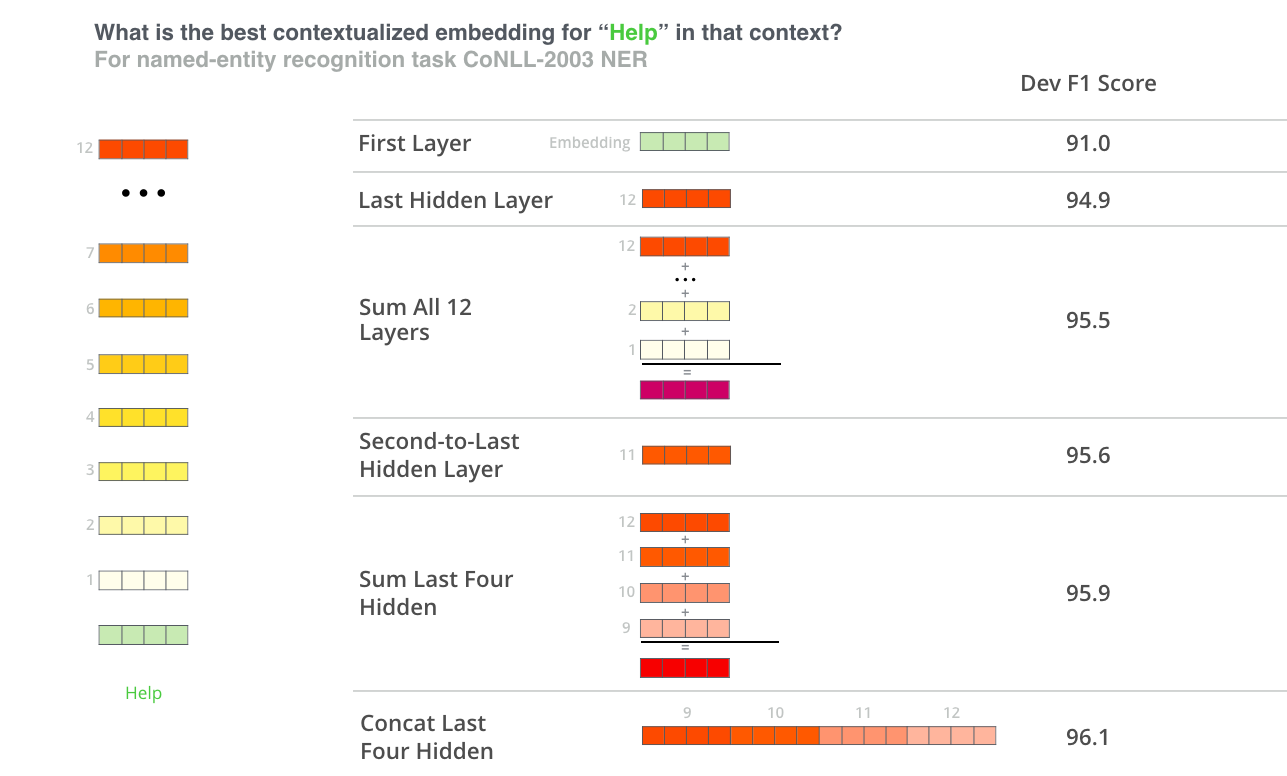

The above was used to better understand alternative sentence embedding definitions. However, using an sum of last 4 layers sentence embedding definition performed (slightly) worse. The types of examples it underperformed on was also consistent with the use of the final layer only.

Hence, we can conclude that the sentence embedding definition will not have a meaningful impact to accuracy.